In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

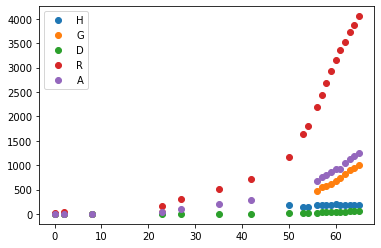

In [3]:
time = [0,2,8,23,27,35,42,50,53,54,56,57,58, 59,60,61,62,63, 64,65]
S = [141105] + [None]*(len(time)-1)
R = [54874] + [None]*(len(time)-1)
H = [0, 0, 0, 11, None, None, None, 189, 147, 147, 183, 176, 193,  190, 197, 189, 191, 183,  174,177]
G = [4, 7, 7, 37, None, None, None, None, None, None, 471, 558, 572,  620, 676, 727, 809, 893,  949,1009]
D = [0, 0, 1, 1, 3, 3, 6, 16, 20, 22, 25, 32, 33,  39, 42, 44, 48, 53,  55,60]
cE = [28, 36, None, 169, 314, 513, 716, 1174, 1644, 1797, 2194, 2437, 2686,  2936, 3149, 3357, 3530, 3728,  3881,4052]
cH = [4, 7, 8, 49, 91, 195, 290, None, None, None, 679, 766, 798,  849, 915, 915, 1048, 1129,  1178,1246]

plt.plot(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

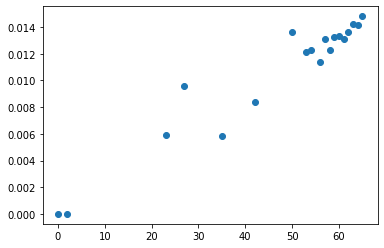

In [4]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [5]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 2
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 63*2,
    "basis_number": 31,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.5],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        [1]*len(data_time)
    ],
    "regularisation_value": copy(p0),
}

In [6]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [7]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [8]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [9]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

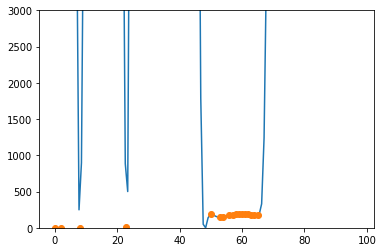

In [10]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [11]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 220  2.2063102e+02 0.00e+00 5.26e-02  -8.6 2.92e+03 -14.1 8.99e-04 1.29e-01f  1
 230  2.2063095e+02 0.00e+00 4.25e-02  -8.6 1.51e+03 -14.3 2.15e-01 7.91e-01f  1
 240  2.2063091e+02 0.00e+00 8.46e-02  -8.6 2.74e+03 -14.6 7.38e-01 1.00e+00h  1
 250  2.2063090e+02 0.00e+00 1.63e-02  -8.6 5.08e+02 -13.9 1.00e+00 1.00e+00h  1
 260  2.2063083e+02 0.00e+00 3.91e-02  -8.6 9.53e+03 -14.2 9.54e-01 2.62e-01f  2
 270  2.2063078e+02 0.00e+00 2.34e-03  -8.6 1.03e+02 -10.8 1.00e+00 1.00e+00f  1
 280  2.2063077e+02 0.00e+00 3.37e-04  -8.6 7.53e+01 -12.0 1.00e+00 1.00e+00h  1
 290  2.2063076e+02 0.00e+00 9.81e-04  -8.6 3.00e+02 -13.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.2063074e+02 0.00e+00 4.98e-03  -8.6 6.62e+01 -11.6 1.00e+00 1.00e+00h  1
 310  2.2063073e+02 0.00e+00 3.71e-03  -8.6 5.13e+01 -11.0 1.00e+00 1.00e+00h  1
 320  2.2063073e+02 0.00e+00 2.90e-02  -8.6 3.29e+01  -9.4 3.48e-01 1.00e+00H  1
 330  2.2063072e+02 0.00e+00

  20  2.2185881e+02 0.00e+00 3.46e+01  -2.5 1.27e+04    -  4.22e-01 7.33e-01f  1
  30  2.2121791e+02 0.00e+00 1.23e-01  -5.7 1.99e+03  -9.2 7.83e-02 3.61e-01f  1
  40  2.2070365e+02 0.00e+00 3.58e-02  -5.7 3.32e+03 -12.2 1.00e+00 1.00e+00f  1
  50  2.2070275e+02 0.00e+00 3.21e-01  -5.7 5.87e+03 -13.4 1.00e+00 1.25e-01f  4
  60  2.2070190e+02 0.00e+00 2.22e-01  -5.7 8.31e+02 -12.7 1.00e+00 1.00e+00f  1
  70  2.2070026e+02 0.00e+00 4.23e-02  -5.7 4.53e+03 -13.9 1.00e+00 5.00e-01f  2
  80  2.2069923e+02 0.00e+00 2.93e-02  -5.7 1.01e+02 -10.9 1.00e+00 1.00e+00f  1
  90  2.2069878e+02 0.00e+00 2.02e-01  -5.7 1.01e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2069862e+02 0.00e+00 1.77e-02  -5.7 6.36e+01 -10.7 1.00e+00 1.00e+00h  1
 110  2.2069846e+02 0.00e+00 3.64e-02  -5.7 1.03e+03 -13.1 1.00e+00 1.00e+00h  1
 120  2.2069827e+02 0.00e+00 1.09e-01  -5.7 8.89e+02 -15.1 1.00e+00 1.00e+00h  1
 130  2.2069812e+02 0.00e+00

 200  2.2074289e+02 0.00e+00 7.54e-07  -8.6 1.47e+01 -11.9 1.00e+00 1.00e+00h  1
 210  2.2074287e+02 0.00e+00 8.42e-05  -8.6 4.77e+00 -10.4 1.00e+00 1.00e+00h  1
 220  2.2074287e+02 0.00e+00 2.55e-02  -8.6 8.44e+02 -13.3 1.00e+00 1.91e-12h 37
 230  2.2074285e+02 0.00e+00 2.13e-05  -8.6 1.79e+01 -11.8 1.00e+00 1.00e+00h  1
 240  2.2074282e+02 0.00e+00 3.96e-02  -8.6 2.87e+03 -13.9 4.69e-01 1.00e+00h  1
 250  2.2074282e+02 0.00e+00 7.04e-07  -8.6 7.41e+01 -12.3 1.00e+00 1.00e+00h  1
 260  2.2074280e+02 0.00e+00 8.71e-04  -8.6 2.09e+01 -11.7 1.00e+00 1.00e+00h  1
 270  2.2074278e+02 0.00e+00 2.65e-05  -8.6 1.54e+01 -11.0 1.00e+00 1.00e+00h  1
 280  2.2074275e+02 0.00e+00 2.60e-05  -8.6 8.38e+01 -12.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 287

                                   (scaled)                 (unscaled)
Objective...............:   2.2074274195196375e+02    2.2074274195196375e+02
Dual infeasibility......:   1.1717694382827606e-10    1.1717694382827606e-10
Constraint vio

  30  2.2092644e+02 0.00e+00 7.25e-01  -5.7 1.87e+03 -10.2 1.42e-01 4.93e-01f  1
  40  2.2089256e+02 0.00e+00 4.30e-01  -5.7 2.11e+03 -12.3 1.00e+00 1.00e+00f  1
  50  2.2089015e+02 0.00e+00 1.07e-01  -5.7 6.17e+03 -13.8 1.00e+00 5.00e-01f  2
  60  2.2088950e+02 0.00e+00 4.09e-02  -5.7 1.21e+02 -10.9 1.00e+00 1.00e+00f  1
  70  2.2088910e+02 0.00e+00 4.20e-01  -5.7 8.75e+02 -12.9 1.00e+00 1.00e+00f  1
  80  2.2088871e+02 0.00e+00 2.40e-01  -5.7 7.57e+01 -10.0 1.00e+00 1.00e+00h  1
  90  2.2088836e+02 0.00e+00 3.53e-01  -5.7 7.74e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2088769e+02 0.00e+00 1.28e-01  -5.7 4.89e+02 -12.7 1.00e+00 1.00e+00f  1
 110  2.2088712e+02 0.00e+00 4.54e-02  -5.7 1.13e+02 -10.3 1.00e+00 1.00e+00h  1
 120  2.2088644e+02 0.00e+00 3.68e-01  -5.7 4.89e+02 -12.4 1.00e+00 1.00e+00f  1
 130  2.2088590e+02 0.00e+00 3.43e-01  -5.7 1.68e+03 -13.5 1.00e+00 5.00e-01f  2
 140  2.2088549e+02 0.00e+00

  40  2.2111414e+02 0.00e+00 2.24e-02  -5.7 1.98e+02 -10.0 1.00e+00 1.00e+00f  1
  50  2.2111110e+02 0.00e+00 2.16e-01  -5.7 3.04e+02 -12.0 1.00e+00 1.00e+00f  1
  60  2.2110985e+02 0.00e+00 2.06e-01  -5.7 3.12e+02 -12.3 1.00e+00 1.00e+00f  1
  70  2.2110840e+02 0.00e+00 4.04e-01  -5.7 4.04e+02 -12.6 1.00e+00 1.00e+00f  1
  80  2.2110677e+02 0.00e+00 2.39e-02  -5.7 2.01e+01  -8.3 1.00e+00 1.00e+00f  1
  90  2.2110547e+02 0.00e+00 6.54e-01  -5.7 7.54e+02 -13.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2110429e+02 0.00e+00 3.89e-01  -5.7 1.09e+03 -12.8 1.00e+00 1.00e+00f  1
 110  2.2110349e+02 0.00e+00 2.71e-01  -5.7 1.36e+03 -13.1 1.00e+00 5.00e-01f  2
 120  2.2110194e+02 0.00e+00 3.30e-03  -5.7 5.74e+02 -12.5 1.00e+00 1.00e+00f  1
 130  2.2110104e+02 0.00e+00 1.51e-03  -5.7 1.42e+01  -9.5 1.00e+00 1.00e+00f  1
 140  2.2110102e+02 0.00e+00 1.31e-03  -8.6 9.46e+00  -8.2 9.66e-01 9.40e-01f  1
 150  2.2110093e+02 0.00e+00

 100  2.2144369e+02 0.00e+00 3.71e-01  -5.7 2.04e+03    -  8.38e-01 1.85e-01f  3
 110  2.2144361e+02 0.00e+00 2.85e-06  -5.7 1.63e+01    -  1.00e+00 1.00e+00h  1
 120  2.2144333e+02 0.00e+00 1.87e-03  -8.6 1.11e+02 -11.8 1.00e+00 9.45e-01h  1
 130  2.2144320e+02 0.00e+00 1.08e-03  -8.6 2.21e+02 -12.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 137

                                   (scaled)                 (unscaled)
Objective...............:   2.2144316035803504e+02    2.2144316035803504e+02
Dual infeasibility......:   9.2758063309725862e-11    9.2758063309725862e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5546378932891039e-09    2.5546378932891039e-09
Overall NLP error.......:   2.5546378932891039e-09    2.5546378932891039e-09


Number of objective function evaluations             = 188
Number of objective gradient evaluations             = 138
Number of equality constraint evaluations            = 0
Number of i

  20  2.2601121e+02 0.00e+00 2.19e+02  -1.7 2.19e+04    -  8.00e-01 1.00e+00f  1
  30  2.2240804e+02 0.00e+00 2.57e+00  -5.7 1.13e+03  -8.8 6.74e-01 1.65e-01f  1
  40  2.2203677e+02 0.00e+00 2.02e+00  -5.7 1.09e+04 -11.7 1.14e-01 7.16e-02f  1
  50  2.2203063e+02 0.00e+00 1.15e+00  -5.7 3.71e+03 -12.0 1.00e+00 1.25e-01f  4
  60  2.2201995e+02 0.00e+00 1.42e+01  -5.7 4.74e+03 -12.2 1.00e+00 1.00e+00f  1
  70  2.2200246e+02 0.00e+00 1.64e+00  -5.7 1.54e+03 -11.6 1.00e+00 5.00e-01f  2
  80  2.2200067e+02 0.00e+00 4.75e+00  -5.7 5.90e+03 -13.7 1.00e+00 5.00e-01f  2
  90  2.2199977e+02 0.00e+00 1.57e-01  -5.7 3.63e+04    -  1.00e+00 1.00e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2199915e+02 0.00e+00 8.95e-02  -5.7 6.37e+01 -10.5 1.00e+00 1.00e+00h  1
 110  2.2199862e+02 0.00e+00 1.35e+00  -5.7 1.63e+03 -13.5 1.00e+00 5.00e-01f  2
 120  2.2199808e+02 0.00e+00 7.72e-01  -5.7 1.50e+02 -10.5 1.00e+00 1.00e+00f  1
 130  2.2199750e+02 0.00e+00

  50  2.2278921e+02 0.00e+00 1.03e+00  -5.7 3.34e+03 -12.0 1.00e+00 1.28e-01f  3
  60  2.2278399e+02 0.00e+00 2.46e+00  -5.7 1.31e+03 -12.3 1.00e+00 5.00e-01f  2
  70  2.2277761e+02 0.00e+00 3.07e+00  -5.7 1.81e+03 -11.7 1.00e+00 2.80e-01f  2
  80  2.2277067e+02 0.00e+00 6.56e-01  -5.7 1.64e+03 -11.9 1.00e+00 1.35e-01f  3
  90  2.2276666e+02 0.00e+00 4.52e-02  -5.7 3.42e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2276502e+02 0.00e+00 1.73e-01  -5.7 2.00e+03 -12.4 1.00e+00 1.00e+00f  1
 110  2.2276375e+02 0.00e+00 9.37e-04  -5.7 2.53e+00  -8.0 1.00e+00 1.00e+00f  1
 120  2.2276276e+02 0.00e+00 7.72e-02  -5.7 1.36e+02 -11.3 1.00e+00 1.00e+00f  1
 130  2.2275935e+02 0.00e+00 1.97e+00  -5.7 2.41e+03 -12.5 5.98e-01 1.00e+00f  1
 140  2.2275868e+02 0.00e+00 4.52e-02  -5.7 8.12e+02 -12.8 1.00e+00 1.00e+00h  1
 150  2.2275830e+02 0.00e+00 2.83e-04  -5.7 1.51e+02    -  1.00e+00 1.00e+00h  1
 160  2.2275793e+02 0.00e+00

Solving for p=8.697490026177834e-05
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|| 

  70  2.2536511e+02 0.00e+00 1.69e+01  -5.7 7.79e+02 -11.4 1.00e+00 1.00e+00f  1
  80  2.2535814e+02 0.00e+00 5.25e+00  -5.7 5.16e+02 -11.7 1.00e+00 1.00e+00f  1
  90  2.2535049e+02 0.00e+00 5.56e+00  -5.7 6.79e+02 -12.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2534211e+02 0.00e+00 6.91e+00  -5.7 2.86e+03 -12.2 3.70e-01 1.00e+00f  1
 110  2.2533431e+02 0.00e+00 8.59e+00  -5.7 6.06e+02 -11.6 1.00e+00 1.00e+00f  1
 120  2.2532719e+02 0.00e+00 3.33e+00  -5.7 7.78e+02 -11.8 1.00e+00 1.00e+00f  1
 130  2.2532068e+02 0.00e+00 2.21e+00  -5.7 3.18e+02 -11.2 1.00e+00 1.00e+00f  1
 140  2.2531442e+02 0.00e+00 1.59e+00  -5.7 2.93e+02 -10.5 1.00e+00 1.00e+00f  1
 150  2.2530978e+02 0.00e+00 8.49e-01  -5.7 8.56e+01  -9.0 1.00e+00 1.00e+00f  1
 160  2.2530693e+02 0.00e+00 3.51e-01  -5.7 1.14e+03 -11.9 1.00e+00 1.00e+00f  1
 170  2.2530615e+02 0.00e+00 1.11e-01  -5.7 2.79e+02 -11.3 1.00e+00 1.00e+00f  1
 180  2.2530462e+02 0.00e+00

 140  2.2710986e+02 0.00e+00 1.02e+01  -5.7 2.05e+02  -8.7 1.00e+00 1.25e-01f  4
 150  2.2710729e+02 0.00e+00 6.55e-02  -5.7 4.78e+01  -9.4 1.00e+00 1.00e+00h  1
 160  2.2710353e+02 0.00e+00 2.28e+01  -5.7 3.07e+04    -  1.00e+00 2.50e-01f  3
 170  2.2709929e+02 0.00e+00 2.75e-01  -5.7 7.77e+01  -9.4 1.00e+00 1.00e+00f  1
 180  2.2709599e+02 0.00e+00 1.99e-03  -5.7 1.05e+01  -8.8 1.00e+00 1.00e+00h  1
 190  2.2709059e+02 0.00e+00 4.28e+00  -5.7 1.49e+02  -9.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.2708438e+02 0.00e+00 2.32e-01  -5.7 3.50e+01  -8.7 1.00e+00 1.00e+00f  1
 210  2.2708078e+02 0.00e+00 3.53e+00  -5.7 4.27e+03    -  1.00e+00 1.25e-01f  4
 220  2.2707970e+02 0.00e+00 5.15e-04  -5.7 6.55e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 229

                                   (scaled)                 (unscaled)
Objective...............:   2.2707946280977691e+02    2.2707946280977691e+02
Dual infea

  20  2.4565452e+02 0.00e+00 6.88e+00  -2.5 2.54e+02  -5.9 1.00e+00 6.30e-01f  1
  30  2.3237493e+02 0.00e+00 9.06e+01  -2.5 2.92e+03 -10.2 1.00e+00 1.00e+00f  1
  40  2.3239295e+02 0.00e+00 2.42e+01  -2.5 4.21e+03 -10.4 9.05e-01 1.25e-01f  4
  50  2.3239484e+02 0.00e+00 1.42e+00  -2.5 1.79e+02  -9.6 1.00e+00 1.00e+00f  1
  60  2.3240546e+02 0.00e+00 1.31e+00  -2.5 1.03e+03 -10.1 1.00e+00 2.50e-01f  3
  70  2.3241932e+02 0.00e+00 2.43e-02  -2.5 2.06e+01    -  1.00e+00 1.00e+00h  1
  80  2.3203234e+02 0.00e+00 3.58e+00  -3.8 1.60e+02 -10.8 1.00e+00 1.00e+00f  1
  90  2.3202332e+02 0.00e+00 1.39e+01  -3.8 2.92e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3201202e+02 0.00e+00 1.78e+01  -3.8 2.40e+04    -  9.02e-02 3.57e-02f  5
 110  2.3199710e+02 0.00e+00 3.58e-01  -3.8 1.35e+01  -8.2 1.00e+00 1.00e+00f  1
 120  2.3198431e+02 0.00e+00 6.06e+00  -3.8 4.18e+02 -11.2 1.00e+00 1.00e+00f  1
 130  2.3196533e+02 0.00e+00

 360  2.3369264e+02 0.00e+00 6.52e-01  -5.7 9.82e+01  -9.5 1.00e+00 1.00e+00f  1
 370  2.3367784e+02 0.00e+00 1.27e+01  -5.7 9.36e+02 -10.7 1.00e+00 1.00e+00f  1
 380  2.3366751e+02 0.00e+00 1.51e+00  -5.7 1.64e+03 -10.9 1.00e+00 2.50e-01f  3
 390  2.3365659e+02 0.00e+00 2.14e+01  -5.7 1.75e+03 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.3364309e+02 0.00e+00 1.64e-02  -5.7 1.28e+01  -8.2 1.00e+00 1.00e+00f  1
 410  2.3362964e+02 0.00e+00 3.47e+00  -5.7 3.15e+02  -9.8 1.00e+00 1.00e+00f  1
 420  2.3361661e+02 0.00e+00 1.89e+00  -5.7 2.13e+02  -9.6 1.00e+00 1.00e+00f  1
 430  2.3360140e+02 0.00e+00 5.11e+00  -5.7 1.42e+04    -  7.11e-01 1.19e-01f  4
 440  2.3359713e+02 0.00e+00 2.00e-04  -5.7 1.01e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 448

                                   (scaled)                 (unscaled)
Objective...............:   2.3359690448128148e+02    2.3359690448128148e+02
Dual infea

  30  2.3807458e+02 0.00e+00 1.39e+01  -3.8 3.72e+02  -9.4 1.00e+00 5.00e-01f  2
  40  2.3800093e+02 0.00e+00 4.03e+00  -3.8 1.41e+04    -  1.08e-01 1.76e-02f  4
  50  2.3798060e+02 0.00e+00 5.75e+00  -3.8 2.32e+04    -  8.83e-01 5.00e-01f  2
  60  2.3796209e+02 0.00e+00 2.98e-04  -5.7 1.70e+03    -  1.00e+00 1.00e+00h  1
  70  2.3796188e+02 0.00e+00 7.37e-10  -9.0 1.07e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   2.3796188213124555e+02    2.3796188213124555e+02
Dual infeasibility......:   7.3714774700727563e-10    7.3714774700727563e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2987810981731205e-10    9.2987810981731205e-10
Overall NLP error.......:   9.2987810981731205e-10    9.2987810981731205e-10


Number of objective function evaluations             = 111
Number of objective gradient evaluations       

  40  2.6409469e+02 0.00e+00 1.64e+03  -1.0 3.57e+04  -9.0 2.83e-02 1.99e-02f  1
  50  2.6404543e+02 0.00e+00 8.57e+02  -1.0 5.41e+03  -9.1 1.00e+00 7.55e-01f  1
  60  2.6454167e+02 0.00e+00 5.49e+02  -1.0 2.02e+03 -10.2 1.00e+00 1.00e+00f  1
  70  2.5053471e+02 0.00e+00 4.55e+02  -1.7 5.21e+03    -  1.00e+00 6.97e-01f  1
  80  2.4768437e+02 0.00e+00 5.87e+00  -3.8 6.16e+02  -9.9 1.00e+00 1.00e+00f  1
  90  2.4743782e+02 0.00e+00 2.36e+01  -3.8 6.69e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4728140e+02 0.00e+00 8.73e+01  -3.8 1.66e+03 -10.4 1.00e+00 1.00e+00f  1
 110  2.4693362e+02 0.00e+00 4.90e+02  -3.8 2.99e+03  -9.7 1.00e+00 1.00e+00f  1
 120  2.4552820e+02 0.00e+00 1.50e+02  -3.8 9.02e+02  -9.1 1.00e+00 1.00e+00f  1
 130  2.4480447e+02 0.00e+00 9.71e+00  -3.8 1.13e+05    -  1.05e-01 1.50e-02f  6
 140  2.4478302e+02 0.00e+00 5.81e-01  -3.8 7.38e+01  -8.6 1.00e+00 1.00e+00f  1
 150  2.4475486e+02 0.00e+00

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5030287e+02 0.00e+00 2.54e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.6349390e+02 0.00e+00 7.20e-01  -1.0 4.44e+00  -4.0 1.00e+00 1.00e+00f  1
  20  2.5088626e+02 0.00e+00 2.23e-01  -2.5 3.99e+01  -6.9 1.00e+00 1.00e+00f  1
  30  2.5090175e+02 0.00e+00 2.60e-02  -2.5 5.50e+00  -6.1 1.00e+00 1.00e+00f  1
  40  2.5033773e+0

  80  2.9062318e+02 0.00e+00 8.20e+02  -1.0 3.72e+03    -  1.00e+00 5.00e-01f  2
  90  2.9061378e+02 0.00e+00 3.48e+02  -1.0 1.59e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7783280e+02 0.00e+00 5.20e+02  -1.7 9.37e+02  -9.9 1.00e+00 1.00e+00f  1
 110  2.7498864e+02 0.00e+00 2.02e+02  -2.5 2.27e+03 -10.9 1.00e+00 1.00e+00f  1
 120  2.7464647e+02 0.00e+00 2.99e+02  -2.5 2.40e+03 -10.2 1.00e+00 5.00e-01f  2
 130  2.7425286e+02 0.00e+00 1.64e+02  -2.5 5.50e+03 -10.4 1.00e+00 1.25e-01f  4
 140  2.7339895e+02 0.00e+00 5.66e+02  -2.5 5.98e+04    -  5.78e-01 8.33e-02f  4
 150  2.6949719e+02 0.00e+00 1.56e+03  -2.5 1.60e+04  -9.5 6.20e-02 3.56e-02f  4
 160  2.6612019e+02 0.00e+00 3.26e+00  -2.5 1.35e+02  -8.3 1.00e+00 1.00e+00f  1
 170  2.6611301e+02 0.00e+00 7.45e+01  -2.5 5.68e+02  -9.4 1.00e+00 1.00e+00f  1
 180  2.6610623e+02 0.00e+00 1.99e+01  -2.5 6.49e+02 -10.1 1.00e+00 1.00e+00f  1
 190  2.6607832e+02 0.00e+00

 150  2.8264596e+02 0.00e+00 9.13e+02  -2.5 1.06e+03 -10.0 1.00e+00 1.00e+00f  1
 160  2.7579026e+02 0.00e+00 4.28e+01  -2.5 3.45e+02  -7.6 1.00e+00 1.00e+00f  1
 170  2.7434162e+02 0.00e+00 1.16e+01  -2.5 2.30e+02  -9.2 1.00e+00 1.00e+00f  1
 180  2.7431376e+02 0.00e+00 8.45e+01  -2.5 9.44e+02  -9.8 1.00e+00 5.00e-01f  2
 190  2.7429799e+02 0.00e+00 4.76e+01  -2.5 3.54e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.7426771e+02 0.00e+00 1.52e+02  -2.5 5.74e+04    -  7.24e-01 6.40e-02f  3
 210  2.7421525e+02 0.00e+00 1.76e+02  -2.5 9.85e+02  -9.0 4.05e-01 2.50e-01f  3
 220  2.7416263e+02 0.00e+00 5.91e+02  -2.5 3.39e+03 -10.6 1.00e+00 4.89e-01f  2
 230  2.7408135e+02 0.00e+00 4.08e+02  -2.5 2.35e+04 -11.7 1.00e+00 2.50e-01f  3
 240  2.7399374e+02 0.00e+00 6.25e+02  -2.5 6.72e+03 -11.0 1.00e+00 2.89e-01f  2
 250  2.7388318e+02 0.00e+00 4.04e+00  -2.5 4.24e+02  -9.4 1.00e+00 1.00e+00f  1
 260  2.7374973e+02 0.00e+00

 200  2.8378837e+02 0.00e+00 1.07e+00  -2.5 5.13e+01  -7.9 1.00e+00 1.00e+00f  1
 210  2.8351897e+02 0.00e+00 9.14e+01  -2.5 6.81e+02  -8.6 1.00e+00 5.00e-01f  2
 220  2.8312059e+02 0.00e+00 1.03e+01  -2.5 1.79e+02  -8.0 1.00e+00 1.00e+00f  1
 230  2.8265205e+02 0.00e+00 9.27e+00  -2.5 7.66e+01  -7.3 1.00e+00 1.00e+00f  1
 240  2.8194275e+02 0.00e+00 5.28e+01  -2.5 7.55e+02  -7.6 1.00e+00 5.00e-01f  2
 250  2.8119125e+02 0.00e+00 3.20e+01  -2.5 3.78e+03  -7.8 6.68e-01 6.25e-02f  5
 260  2.8003467e+02 0.00e+00 4.76e+01  -2.5 2.09e+02  -7.2 1.00e+00 1.00e+00f  1
 270  2.7917156e+02 0.00e+00 2.83e+01  -2.5 1.30e+02  -7.0 1.00e+00 1.00e+00f  1
 280  2.7798496e+02 0.00e+00 1.84e+01  -2.5 1.03e+04    -  1.00e+00 1.00e+00f  1
 290  2.7766252e+02 0.00e+00 6.40e-01  -2.5 4.75e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.7712752e+02 0.00e+00 5.56e-01  -3.8 2.68e+01  -8.0 1.00e+00 1.00e+00f  1
 310  2.7688651e+02 0.00e+00

 120  3.0713246e+02 0.00e+00 5.69e+02  -2.5 5.28e+02  -9.8 1.00e+00 1.00e+00f  1
 130  3.0649281e+02 0.00e+00 9.62e+02  -2.5 2.24e+03 -10.0 1.00e+00 2.50e-01f  3
 140  3.0573401e+02 0.00e+00 9.35e+02  -2.5 1.19e+03 -10.3 1.00e+00 5.00e-01f  2
 150  3.0491831e+02 0.00e+00 1.07e+03  -2.5 2.16e+03 -10.1 1.00e+00 2.50e-01f  3
 160  3.0392042e+02 0.00e+00 4.18e+02  -2.5 1.91e+03  -8.5 1.00e+00 6.25e-02f  5
 170  3.0267823e+02 0.00e+00 1.55e+03  -2.5 1.51e+03 -10.1 1.00e+00 5.00e-01f  2
 180  3.0132338e+02 0.00e+00 1.50e+02  -2.5 2.27e+02  -8.6 1.00e+00 1.00e+00f  1
 190  2.9974786e+02 0.00e+00 1.10e+03  -2.5 1.20e+03  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.9846214e+02 0.00e+00 9.57e+00  -2.5 9.15e+00  -5.5 1.00e+00 1.00e+00f  1
 210  2.9765402e+02 0.00e+00 6.64e+02  -2.5 7.01e+02  -9.3 1.00e+00 5.00e-01f  2
 220  2.9687300e+02 0.00e+00 5.43e+01  -2.5 3.06e+01  -6.9 1.00e+00 1.00e+00f  1
 230  2.9644045e+02 0.00e+00

 360  3.0497062e+02 0.00e+00 1.15e-01  -5.7 2.45e+00  -5.1 1.00e+00 1.00e+00f  1
 370  3.0444957e+02 0.00e+00 3.93e+02  -5.7 1.94e+04    -  6.40e-02 7.61e-02f  3
 380  3.0382794e+02 0.00e+00 1.21e-01  -5.7 8.19e+00  -5.9 1.00e+00 1.00e+00f  1
 390  3.0358427e+02 0.00e+00 4.65e+00  -5.7 4.12e+01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.0339043e+02 0.00e+00 4.45e+01  -5.7 5.78e+02 -10.4 1.00e+00 1.00e+00f  1
 410  3.0333175e+02 0.00e+00 1.15e+01  -5.7 7.60e+01  -9.2 1.00e+00 1.00e+00f  1
 420  3.0332803e+02 0.00e+00 6.43e-02  -5.7 3.40e+03    -  1.00e+00 1.00e+00h  1
 430  3.0332801e+02 0.00e+00 1.13e-06  -8.6 7.02e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 431

                                   (scaled)                 (unscaled)
Objective...............:   3.0332801108899815e+02    3.0332801108899815e+02
Dual infeasibility......:   3.0567043493702572e-10    3.0567043493702572e-10
Constraint vio

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3071152e+02 0.00e+00 3.37e+00  -1.0 0.00e+00    -  0.00e+00 0.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.7129808e+02 0.00e+00 1.41e+02  -2.5 1.48e+01  -5.6 1.00e+00 1.00e+00f  1
 210  3.6873573e+02 0.00e+00 2.43e+03  -2.5 1.47e+03  -9.5 1.00e+00 2.50e-01f  3
 220  3.6628562e+02 0.00e+00 2.31e+03  -2.5 3.90e+02  -7.9 1.00e+00 1.00e+00f  1
 230  3.6349935e+02 0.00e+00 2.16e+03  -2.5 8.12e+02  -9.1 1.00e+00 5.00e-01f  2
 240  3.6116091e+02 0.00e+00 1.21e+03  -2.5 6.78e+01  -6.6 1.00e+00 5.00e-01f  2
 250  3.5952265e+02 0.00e+00 5.64e+02  -2.5 2.20e+01  -6.0 1.00e+00 1.00e+00f  1
 260  3.5830238e+02 0.00e+00 3.25e+02  -2.5 2.39e+01  -5.3 1.00e+00 5.00e-01f  2
 270  3.5730991e+02 0.00e+00 4.00e+02  -2.5 9.00e+00  -4.7 1.00e+00 1.00e+00f  1
 280  3.5691163e+02 0.00e+00 1.85e+02  -2.5 1.56e+01  -5.9 1.00e+00 5.00e-01f  2
 290  3.5653926e+02 0.00e+00 8.02e-01  -2.5 1.40e+00  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.5602966e+02 0.00e+00

  20  4.0125685e+02 0.00e+00 2.33e+02  -1.0 4.42e+03    -  7.03e-01 2.50e-01f  3
  30  3.8642554e+02 0.00e+00 7.84e+00  -1.7 1.35e+01  -4.8 1.00e+00 1.00e+00f  1
  40  3.7693770e+02 0.00e+00 2.73e+01  -1.7 1.04e+04    -  9.78e-01 1.00e+00f  1
  50  3.7395475e+02 0.00e+00 6.66e-01  -2.5 2.89e+00  -5.5 1.00e+00 1.00e+00f  1
  60  3.7379577e+02 0.00e+00 2.98e+00  -5.7 4.85e+04    -  1.00e+00 2.76e-01f  2
  70  3.7379315e+02 0.00e+00 8.16e-08  -8.6 6.18e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:   3.7379314613222283e+02    3.7379314613222283e+02
Dual infeasibility......:   1.5895610249075166e-09    1.5895610249075166e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.4289076588783632e-09    3.4289076588783632e-09
Overall NLP error.......:   3.4289076588783632e-09    3.4289076588783632e-09


Number of objective funct

  30  4.3351381e+02 0.00e+00 3.18e-08  -5.7 5.86e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   4.3351373562176968e+02    4.3351373562176968e+02
Dual infeasibility......:   2.7745903546901630e-11    2.7745903546901630e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2628569167077284e-10    9.2628569167077284e-10
Overall NLP error.......:   9.2628569167077284e-10    9.2628569167077284e-10


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w

  30  5.2694369e+02 0.00e+00 2.72e+00  -5.7 3.67e+03    -  1.00e+00 1.83e-01f  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   5.2694313116371347e+02    5.2694313116371347e+02
Dual infeasibility......:   1.1472519193179549e-09    1.1472519193179549e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.0487792062023041e-09    3.0487792062023041e-09
Overall NLP error.......:   3.0487792062023041e-09    3.0487792062023041e-09


Number of objective function evaluations             = 48
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 48
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w

  30  6.7968795e+02 0.00e+00 1.39e-04  -5.7 4.89e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   6.7968789463897156e+02    6.7968789463897156e+02
Dual infeasibility......:   4.2859643804770963e-10    4.2859643804770963e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2192813961205876e-09    3.2192813961205876e-09
Overall NLP error.......:   3.2192813961205876e-09    3.2192813961205876e-09


Number of objective function evaluations             = 41
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 41
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w

       total  | 199.95ms (199.95ms) 198.81ms (198.81ms)         1
Solving for p=4.641588833612782
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4239
Number of nonzeros in Lagrangian Hessian.............:     7462

Total number of variables............................:      285
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1134
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1134
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5214891e+03 0.00e+00 1.23e+01  -1.0 0.00e+00    -  0.00e+00 0.

  30  1.8935305e+03 0.00e+00 2.65e-01  -1.0 5.86e-02  -2.8 1.00e+00 1.00e+00f  1
  40  1.8875251e+03 0.00e+00 2.61e+00  -5.7 3.88e-01  -4.7 1.00e+00 8.86e-01f  1

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:   1.8874927106647774e+03    1.8874927106647774e+03
Dual infeasibility......:   3.0042819026484707e-11    3.0042819026484707e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3691556346451193e-09    3.3691556346451193e-09
Overall NLP error.......:   3.3691556346451193e-09    3.3691556346451193e-09


Number of objective function evaluations             = 80
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 80
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 49
Num

  20  2.2294587e+03 0.00e+00 1.46e+00  -1.7 1.45e-01  -2.5 1.00e+00 1.00e+00f  1
  30r 2.2741666e+03 0.00e+00 2.31e-06  -5.7 2.47e-02    -  9.90e-01 1.00e+00h  1
  40  2.2285538e+03 0.00e+00 6.60e+00  -3.8 3.19e+04    -  1.00e+00 1.25e-01f  4
  50  2.2285485e+03 0.00e+00 1.08e+01  -8.6 6.17e+04    -  3.92e-01 8.20e-02f  4
  60  2.2285444e+03 0.00e+00 3.21e-02  -8.6 2.25e+02 -10.8 1.00e+00 1.00e+00f  1
  70  2.2285371e+03 0.00e+00 1.29e+01  -8.6 4.43e+03 -11.1 1.00e+00 2.50e-01f  3
  80  2.2285282e+03 0.00e+00 2.37e+00  -8.6 2.85e+02 -10.4 1.00e+00 1.00e+00f  1
  90  2.2285189e+03 0.00e+00 4.47e+00  -8.6 1.07e+03 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2285072e+03 0.00e+00 1.29e+00  -8.6 1.77e+02 -10.0 1.00e+00 1.00e+00f  1
 110  2.2284883e+03 0.00e+00 1.13e+01  -8.6 2.27e+03 -10.3 1.00e+00 2.50e-01f  3
 120  2.2284670e+03 0.00e+00 1.50e+01  -8.6 1.69e+03 -10.5 1.00e+00 5.00e-01f  2
 130  2.2284354e+03 0.00e+00

  50  2.5246976e+03 0.00e+00 2.37e-03  -8.6 1.80e-03    -  1.00e+00 5.76e-01f  1

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:   2.5246975720226801e+03    2.5246975720226801e+03
Dual infeasibility......:   1.4502292600909858e-09    1.4502292600909858e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7591051619352982e-09    2.7591051619352982e-09
Overall NLP error.......:   2.7591051619352982e-09    2.7591051619352982e-09


Number of objective function evaluations             = 61
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 61
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations             = 51
Total CPU secs in IPOPT (w

  10  2.9303253e+03 0.00e+00 5.43e+01  -1.0 1.88e-01  -2.0 9.96e-01 1.00e+00f  1
  20  2.9239022e+03 0.00e+00 3.49e+02  -3.8 3.12e+03    -  1.00e+00 8.25e-01f  1
  30  2.9237536e+03 0.00e+00 5.89e-04  -8.6 3.88e-03    -  1.00e+00 9.60e-01f  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   2.9237536133165845e+03    2.9237536133165845e+03
Dual infeasibility......:   5.2930855751844720e-10    5.2930855751844720e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.6351433236651045e-09    5.6351433236651045e-09
Overall NLP error.......:   5.6351433236651045e-09    5.6351433236651045e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobia

  20  3.3011989e+03 0.00e+00 4.17e+02  -3.8 3.17e+03    -  1.00e+00 7.77e-01f  1
  30  3.3010707e+03 0.00e+00 4.42e-05  -5.7 1.64e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   3.3010706794073390e+03    3.3010706794073390e+03
Dual infeasibility......:   2.8305785682310201e-09    2.8305785682310201e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.3242653574688662e-09    1.3242653574688662e-09
Overall NLP error.......:   2.8305785682310201e-09    2.8305785682310201e-09


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Num

  20  3.8149212e+03 0.00e+00 1.25e+02  -2.5 1.24e+03    -  9.49e-01 6.79e-01f  1
  30  3.8143311e+03 0.00e+00 2.68e-02  -3.8 1.22e-01  -2.5 1.00e+00 1.00e+00f  1
  40  3.8143246e+03 0.00e+00 3.41e-02  -5.7 1.26e+01  -7.3 1.00e+00 1.00e+00f  1
  50  3.8141681e+03 0.00e+00 4.97e-05  -5.7 3.06e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:   3.8141681262222578e+03    3.8141681262222578e+03
Dual infeasibility......:   2.5006063298909248e-09    2.5006063298909248e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.4705982633805897e-09    1.4705982633805897e-09
Overall NLP error.......:   2.5006063298909248e-09    2.5006063298909248e-09


Number of objective function evaluations             = 81
Number of objective gradient evaluations             = 56
Number of equality constraint evaluations            = 0
Number of ineq

  40  4.5236712e+03 0.00e+00 1.55e-03  -5.7 1.85e-01  -5.5 1.00e+00 1.00e+00h  1
  50  4.5235143e+03 0.00e+00 2.00e+02  -8.6 7.77e+02  -8.5 1.00e+00 5.50e-02f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   4.5234996260220178e+03    4.5234996260220178e+03
Dual infeasibility......:   6.2597729553617226e-09    6.2597729553617226e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1012856264614616e-10    9.1012856264614616e-10
Overall NLP error.......:   6.2597729553617226e-09    6.2597729553617226e-09


Number of objective function evaluations             = 75
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 75
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 58
Num


Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   5.4649326816068669e+03    5.4649326816068669e+03
Dual infeasibility......:   4.2116665934781148e-08    4.2116665934781148e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090951e-10    9.0909090909090951e-10
Overall NLP error.......:   4.2116665934781148e-08    4.2116665934781148e-08


Number of objective function evaluations             = 128
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 128
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 75
Number of Lagrangian Hessian evaluations             = 74
Total CPU secs in IPOPT (w/o function evaluations)   =      0.358
Total CPU secs in NLP function evaluati

  50  6.5912099e+03 0.00e+00 3.49e-01  -5.7 5.86e+01  -8.3 1.00e+00 1.00e+00f  1
  60  6.5911241e+03 0.00e+00 2.64e-01  -5.7 9.95e-04  -0.0 1.00e+00 1.00e+00f  1
  70  6.5911240e+03 0.00e+00 4.87e-02  -5.7 3.76e-02  -4.8 1.00e+00 1.00e+00h  1
  80  6.5910328e+03 0.00e+00 2.79e+02  -5.7 1.25e+03  -9.6 1.00e+00 1.00e+00f  1
  90  6.5910289e+03 0.00e+00 9.96e-05  -5.7 3.53e-01  -6.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.5909843e+03 0.00e+00 2.50e+00  -5.7 6.53e+00    -  1.00e+00 1.00e+00f  1
 110  6.5909843e+03 0.00e+00 1.18e-07  -8.6 2.27e-08    -  1.00e+00 6.25e-02h  5

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Objective...............:   6.5909843397531240e+03    6.5909843397531240e+03
Dual infeasibility......:   1.0478588370461020e-07    1.0478588370461020e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 210  7.3427032e+03 0.00e+00 1.02e+02  -8.6 4.92e+00  -7.2 1.00e+00 1.00e+00f  1
 220  7.3426755e+03 0.00e+00 3.89e+01  -8.6 2.88e-01  -4.8 1.00e+00 1.00e+00f  1
 230  7.3426391e+03 0.00e+00 3.56e+02  -8.6 7.94e+02  -9.6 1.00e+00 1.00e+00f  1
 240  7.3426159e+03 0.00e+00 2.22e-04  -8.6 3.57e-01  -6.2 1.00e+00 1.00e+00h  1
 250  7.3425733e+03 0.00e+00 1.51e-03  -8.6 6.24e-05  -0.7 1.00e+00 1.00e+00h  1
 260  7.3425733e+03 0.00e+00 2.14e-05  -8.6 6.18e-02  -5.4 1.00e+00 1.00e+00h  1
 270  7.3425479e+03 0.00e+00 2.22e+01  -8.6 5.87e+01  -8.4 1.00e+00 1.00e+00f  1
 280  7.3425053e+03 0.00e+00 7.47e-02  -8.6 1.07e+00    -  1.00e+00 1.00e+00h  1
 290  7.3425053e+03 0.00e+00 1.85e-07  -8.6 1.89e-08    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 295

                                   (scaled)                 (unscaled)
Objective...............:   7.3425052974721812e+03    7.3425052974721812e+03
Dual infea

  40  7.9793548e+03 0.00e+00 2.05e+01  -2.5 5.59e-03  -0.5 1.00e+00 1.00e+00f  1
  50  7.9779243e+03 0.00e+00 5.72e+00  -2.5 1.53e-01  -2.8 1.00e+00 1.00e+00f  1
  60  7.9768083e+03 0.00e+00 2.02e+03  -2.5 6.84e+03    -  8.52e-01 1.56e-02f  7
  70  7.9760281e+03 0.00e+00 2.06e+03  -2.5 6.56e+03    -  8.57e-01 1.56e-02f  7
  80  7.9751572e+03 0.00e+00 6.36e-01  -2.5 9.02e-04  -0.1 1.00e+00 1.00e+00f  1
  90  7.9743047e+03 0.00e+00 1.61e+00  -2.5 1.40e-02  -2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.9736515e+03 0.00e+00 9.13e+02  -2.5 1.02e+04    -  1.00e+00 3.91e-03f  9
 110  7.9727736e+03 0.00e+00 4.57e+03  -2.5 4.73e+03    -  8.84e-01 3.12e-02f  6
 120  7.9717255e+03 0.00e+00 4.12e+03  -2.5 1.30e+03    -  1.00e+00 6.25e-02f  5
 130  7.9711748e+03 0.00e+00 5.79e-01  -2.5 3.48e-02  -2.6 1.00e+00 1.00e+00f  1
 140  7.9707551e+03 0.00e+00 1.23e+03  -2.5 3.49e+03    -  1.00e+00 1.56e-02f  7
 150  7.9704496e+03 0.00e+00

  40  8.2444059e+03 0.00e+00 4.32e+03  -1.7 1.64e+00  -3.6 1.00e+00 1.00e+00f  1
  50  8.2435840e+03 0.00e+00 5.58e+03  -1.7 6.52e+03    -  7.92e-01 1.56e-02f  7
  60  8.2424690e+03 0.00e+00 3.94e+03  -2.5 5.72e+03    -  8.24e-01 1.56e-02f  7
  70  8.2417010e+03 0.00e+00 5.25e+03  -2.5 5.30e+03    -  8.57e-01 1.56e-02f  7
  80  8.2410574e+03 0.00e+00 3.71e+03  -2.5 4.71e+03    -  8.46e-01 1.56e-02f  7
  90  8.2405762e+03 0.00e+00 2.46e+00  -2.5 4.74e-02  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.2401540e+03 0.00e+00 2.90e+03  -2.5 3.83e+03    -  8.74e-01 1.56e-02f  7
 110  8.2398360e+03 0.00e+00 6.90e+00  -2.5 4.07e-03  -0.5 1.00e+00 1.00e+00f  1
 120  8.2395043e+03 0.00e+00 1.05e+03  -2.5 2.87e-01  -2.9 1.00e+00 5.00e-01f  2
 130  8.2392677e+03 0.00e+00 3.45e+00  -2.5 5.37e-03  -2.2 1.00e+00 1.00e+00f  1
 140  8.2389023e+03 0.00e+00 1.17e+00  -3.8 4.28e-02  -3.6 1.00e+00 1.00e+00f  1
 150  8.2385314e+03 0.00e+00

 260  8.5161741e+03 0.00e+00 4.19e-03  -5.7 8.85e-05  -2.0 1.00e+00 1.00e+00f  1
 270  8.5161730e+03 0.00e+00 9.51e+01  -5.7 1.80e+04    -  5.10e-01 7.81e-03f  8
 280  8.5161722e+03 0.00e+00 1.18e+02  -5.7 2.04e+04    -  4.84e-01 7.81e-03f  8
 290  8.5161715e+03 0.00e+00 1.85e-03  -5.7 2.49e-04  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  8.5161708e+03 0.00e+00 5.83e-03  -5.7 3.18e-04  -3.0 1.00e+00 1.00e+00h  1
 310  8.5161699e+03 0.00e+00 4.81e-06  -5.7 5.35e-05  -2.3 1.00e+00 1.00e+00h  1
 320  8.5161688e+03 0.00e+00 1.17e+02  -8.6 2.21e+04    -  5.88e-01 7.81e-03f  8
 330  8.5161683e+03 0.00e+00 3.50e-04  -8.6 2.31e-05  -1.7 1.00e+00 1.00e+00f  1
 340  8.5161675e+03 0.00e+00 1.18e+02  -8.6 2.33e+04    -  6.21e-01 7.81e-03f  8
 350  8.5161667e+03 0.00e+00 1.23e-04  -8.6 6.53e-05  -2.4 1.00e+00 1.00e+00f  1
 360  8.5161660e+03 0.00e+00 3.46e+01  -8.6 9.73e-03  -3.5 1.00e+00 1.00e+00f  1
 370  8.5161656e+03 0.00e+00

  20  9.3886516e+03 0.00e+00 3.10e+01  -1.0 1.34e-02   0.9 1.00e+00 1.00e+00f  1
  30  9.3176649e+03 0.00e+00 2.00e+02  -1.0 2.99e-02   0.2 1.00e+00 1.00e+00f  1
  40  9.2643500e+03 0.00e+00 9.64e+04  -1.0 2.51e+03    -  6.88e-01 3.12e-02f  6
  50  9.2057617e+03 0.00e+00 1.21e+05  -1.0 3.08e+03    -  6.28e-01 3.12e-02f  6
  60  9.1524191e+03 0.00e+00 7.66e+02  -1.0 1.40e-01  -0.7 1.00e+00 1.00e+00f  1
  70  9.1004710e+03 0.00e+00 1.12e+05  -1.0 1.86e+03    -  9.05e-01 3.12e-02f  6
  80  9.0506242e+03 0.00e+00 8.43e+04  -1.0 3.48e+03    -  8.60e-01 1.56e-02f  7
  90  9.0020617e+03 0.00e+00 3.15e+01  -1.0 8.01e-03   0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.9645755e+03 0.00e+00 1.03e+01  -1.7 2.07e-02  -0.0 1.00e+00 1.00e+00f  1
 110  8.9318916e+03 0.00e+00 8.89e+02  -1.7 5.83e-02  -0.6 1.00e+00 1.00e+00f  1
 120  8.9105307e+03 0.00e+00 1.41e+00  -1.7 6.74e-03   0.1 1.00e+00 1.00e+00f  1
 130  8.8803559e+03 0.00e+00

 360  9.1821860e+03 0.00e+00 1.16e-06  -8.6 3.40e-09    -  1.00e+00 1.00e+00H  1
 370  9.1821860e+03 0.00e+00 6.05e-07  -8.6 2.85e-08    -  1.00e+00 1.00e+00H  1
 380  9.1821860e+03 0.00e+00 5.82e-06  -8.6 5.42e-08    -  1.00e+00 1.00e+00H  1
 390  9.1821860e+03 0.00e+00 2.14e-06  -8.6 1.22e-07    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  9.1821860e+03 0.00e+00 4.57e-06  -8.6 4.59e-07    -  1.00e+00 1.91e-06f 20
 410  9.1821860e+03 0.00e+00 1.37e-06  -8.6 2.95e-07    -  1.00e+00 1.00e+00h  1
 420  9.1821860e+03 0.00e+00 1.88e-06  -8.6 1.19e-07    -  1.00e+00 1.00e+00F  1
 430  9.1821860e+03 0.00e+00 1.44e-06  -8.6 1.41e-08    -  1.00e+00 1.00e+00H  1
 440  9.1821860e+03 0.00e+00 1.75e-06  -8.6 1.55e-07    -  1.00e+00 1.25e-01f  4
 450  9.1821860e+03 0.00e+00 1.41e-06  -8.6 8.57e-09    -  1.00e+00 1.00e+00H  1
 460  9.1821860e+03 0.00e+00 2.58e-06  -8.6 1.15e-07    -  1.00e+00 1.00e+00F  1
 470  9.1821860e+03 0.00e+00

 250  9.5893341e+03 0.00e+00 2.56e+03  -3.8 5.64e+03    -  9.76e-01 1.17e-01f  4
 260  9.5892751e+03 0.00e+00 1.63e-01  -3.8 2.88e-03  -0.6 1.00e+00 1.00e+00f  1
 270  9.5892739e+03 0.00e+00 1.07e+00  -3.8 2.43e-03  -0.6 1.00e+00 1.00e+00f  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 278

                                   (scaled)                 (unscaled)
Objective...............:   9.5911227726818361e+03    9.5911227726818361e+03
Dual infeasibility......:   1.3947814273822890e+05    1.3947814273822890e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.1221919154183994e-10    3.1221919154183994e-10
Overall NLP error.......:   1.3947814273822890e+05    1.3947814273822890e+05


Number of objective function evaluations             = 815
Number of objective gradient evaluations        

  30  1.0599900e+04 0.00e+00 3.04e+02  -1.0 2.95e-01  -1.9 1.00e+00 1.00e+00f  1
  40  1.0597256e+04 0.00e+00 3.91e+00  -1.0 5.00e-02  -1.2 1.00e+00 1.00e+00f  1
  50  1.0595203e+04 0.00e+00 2.40e+04  -1.0 1.38e+04    -  1.00e+00 3.12e-02f  6
  60  1.0590840e+04 0.00e+00 4.33e+04  -1.7 1.10e+04    -  1.00e+00 3.12e-02f  6
  70  1.0588716e+04 0.00e+00 1.54e+04  -1.7 1.47e+04    -  1.00e+00 3.12e-02f  6
  80  1.0587600e+04 0.00e+00 7.48e+03  -1.7 5.14e-01  -2.4 1.00e+00 1.00e+00f  1
  90  1.0585747e+04 0.00e+00 2.11e+01  -2.5 1.09e-01  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0584291e+04 0.00e+00 1.51e+00  -2.5 1.51e-02  -0.9 1.00e+00 1.00e+00f  1
 110  1.0583094e+04 0.00e+00 6.86e-01  -2.5 3.43e-02  -1.5 1.00e+00 1.00e+00f  1
 120  1.0582685e+04 0.00e+00 2.66e+00  -3.8 2.39e-02  -0.8 1.00e+00 1.00e+00f  1
 130  1.0582565e+04 0.00e+00 6.63e+03  -3.8 8.43e+00  -3.7 1.00e+00 1.25e-01f  4
 140  1.0582238e+04 0.00e+00

1040  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1050  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1060  1.0581347e+04 0.00e+00 2.00e-06  -8.6 1.94e-07    -  1.00e+00 1.00e+00w  1
1070  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1080  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1090  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.0581347e+04 0.00e+00 9.95e-06  -8.6 5.02e-08    -  1.00e+00 7.63e-06f 17
1110  1.0581347e+04 0.00e+00 2.00e-06  -8.6 3.32e-07    -  1.00e+00 1.00e+00w  1
1120  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1130  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1140  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1150  1.0581347e+04 0.00e+00

1980  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
1990  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2010  1.0581347e+04 0.00e+00 9.95e-06  -8.6 1.68e-07    -  1.00e+00 7.63e-06f 17
2020  1.0581347e+04 0.00e+00 1.75e-06  -8.6 3.32e-07    -  1.00e+00 1.00e+00w  1
2030  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2040  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2050  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2060  1.0581347e+04 0.00e+00 9.76e-07  -8.6 1.60e-07    -  1.00e+00 1.00e+00w  1
2070  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2080  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2090  1.0581347e+04 0.00e+00

2920  1.0581347e+04 0.00e+00 9.95e-06  -8.6 8.83e-08    -  1.00e+00 7.63e-06f 17
2930  1.0581347e+04 0.00e+00 1.81e-06  -8.6 3.32e-07    -  1.00e+00 1.00e+00w  1
2940  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2950  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2960  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2970  1.0581347e+04 0.00e+00 1.18e-05  -8.6 2.73e-07    -  1.00e+00 1.00e+00w  1
2980  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
2990  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.0581347e+04 0.00e+00 9.95e-06  -8.6 3.32e-07    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.0581346577220167e+04    1.0581346577220167e+04
Dual infe

 550  1.1175459e+04 0.00e+00 1.29e-06  -8.6 1.36e-08    -  1.00e+00 1.91e-06f 19
 560  1.1175459e+04 0.00e+00 5.98e-06  -8.6 6.43e-07    -  1.00e+00 1.00e+00w  1
 570  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
 580  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
 590  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1175459e+04 0.00e+00 6.35e-06  -8.6 3.94e-07    -  1.00e+00 1.00e+00w  1
 610  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
 620  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
 630  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
 640  1.1175459e+04 0.00e+00 1.54e-05  -8.6 4.43e-07    -  1.00e+00 1.00e+00w  1
 650  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
 660  1.1175459e+04 0.00e+00

1530  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1540  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1550  1.1175459e+04 0.00e+00 6.56e-06  -8.6 3.69e-07    -  1.00e+00 1.00e+00w  1
1560  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1570  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1580  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1590  1.1175459e+04 0.00e+00 1.29e-06  -8.6 4.42e-07    -  1.00e+00 1.91e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.1175459e+04 0.00e+00 6.28e-06  -8.6 6.43e-07    -  1.00e+00 1.00e+00w  1
1610  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1620  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1630  1.1175459e+04 0.00e+00 1.29e-06  -8.6 6.43e-07    -  1.00e+00 1.91e-06f 20
1640  1.1175459e+04 0.00e+00

2540  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2550  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2560  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2570  1.1175459e+04 0.00e+00 4.51e-06  -8.6 1.14e-07    -  1.00e+00 3.81e-06f 18
2580  1.1175459e+04 0.00e+00 1.22e-05  -8.6 4.90e-07    -  1.00e+00 1.00e+00w  1
2590  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2610  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2620  1.1175459e+04 0.00e+00 5.64e-06  -8.6 6.01e-08    -  1.00e+00 1.00e+00w  1
2630  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2640  1.1175459e+04 0.00e+00 4.51e-06  -8.6 4.90e-07    -  1.00e+00 3.81e-06f 19
2650  1.1175459e+04 0.00e+00

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

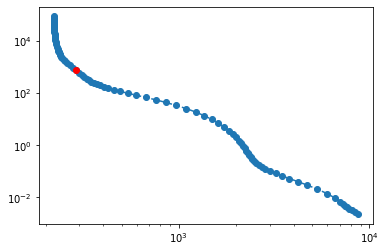

In [13]:
idx = 40
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

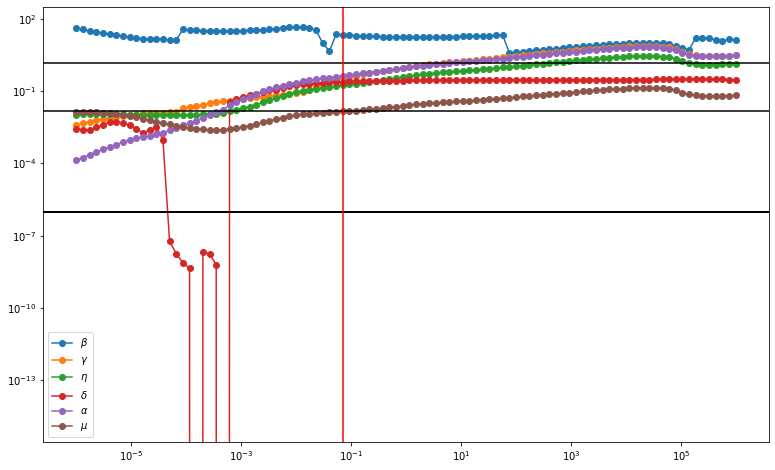

In [14]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

35.1572


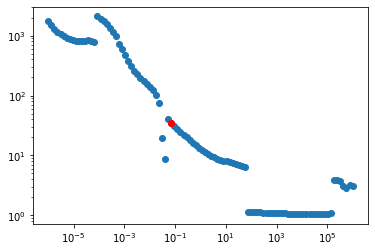

In [15]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

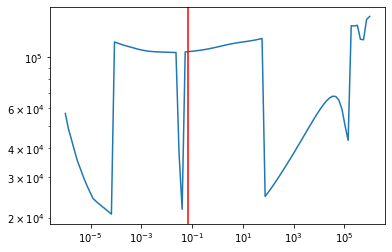

In [16]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(21.8528), DM(0.34481), DM(0.175549), DM(0.246651), DM(0.431702), DM(0.0143243))


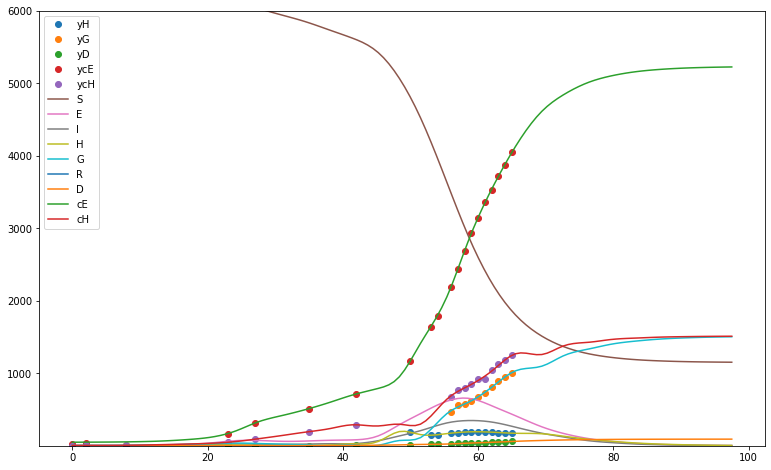

In [17]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 6000])
print(getp(sols[idx]['x']))

In [18]:
print(getp(sols[idx]['x']))
[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

(DM(21.8528), DM(0.34481), DM(0.175549), DM(0.246651), DM(0.431702), DM(0.0143243))


[('s', DM(1887.6)),
 ('e', DM(445.784)),
 ('i', DM(275.111)),
 ('h', DM(175.088)),
 ('g', DM(997.635)),
 ('r', DM(98999.7)),
 ('d', DM(58.8058)),
 ('E', DM(4008.39)),
 ('H', DM(1235.25))]

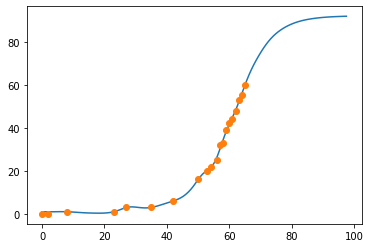

In [19]:
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')

(0, 6000)

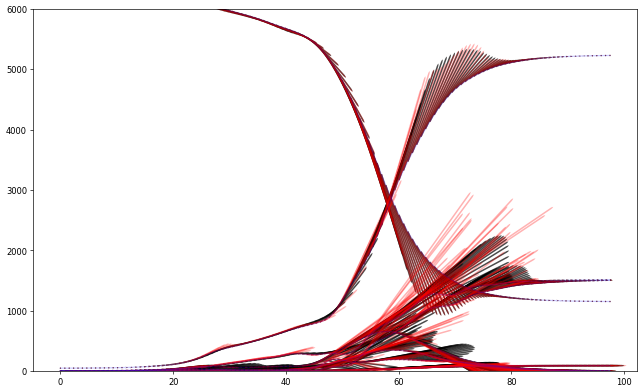

In [20]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

(0, 0.04)

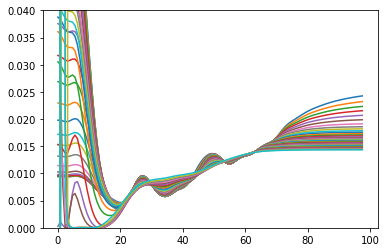

In [21]:
for i in range(30,70):
    plt.plot(model.observation_times, getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])
plt.ylim(0, 0.04)

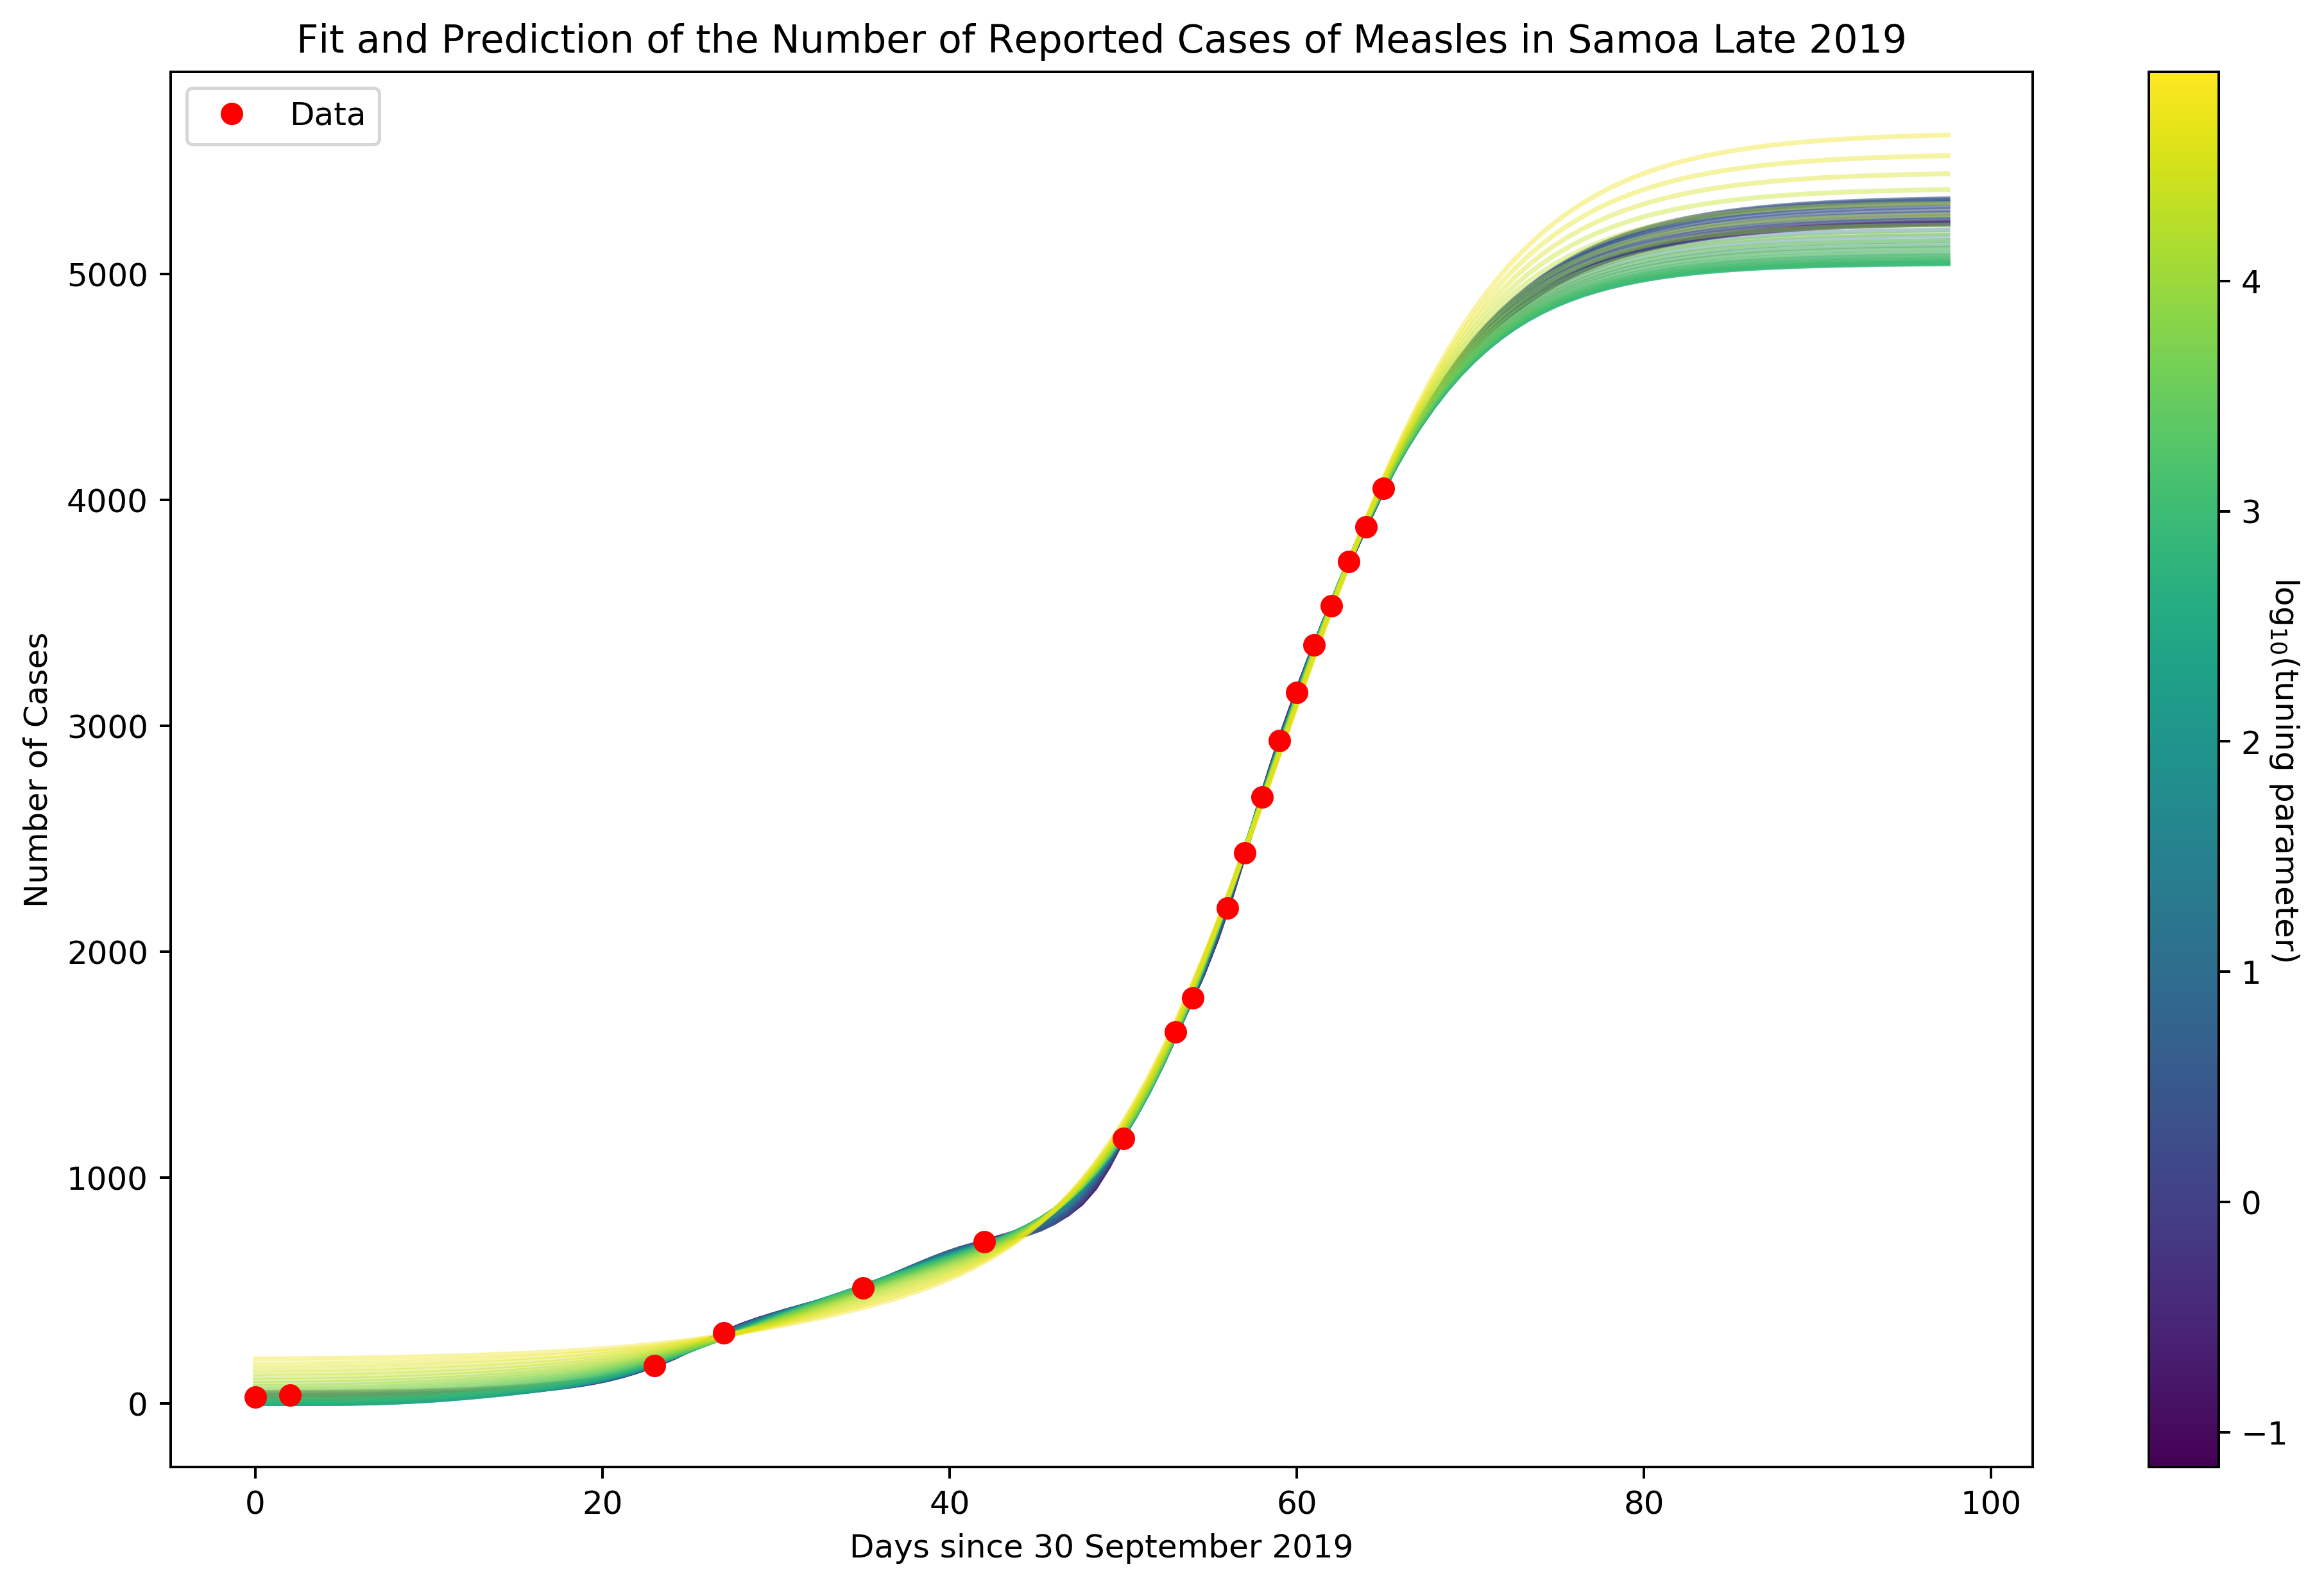

In [22]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

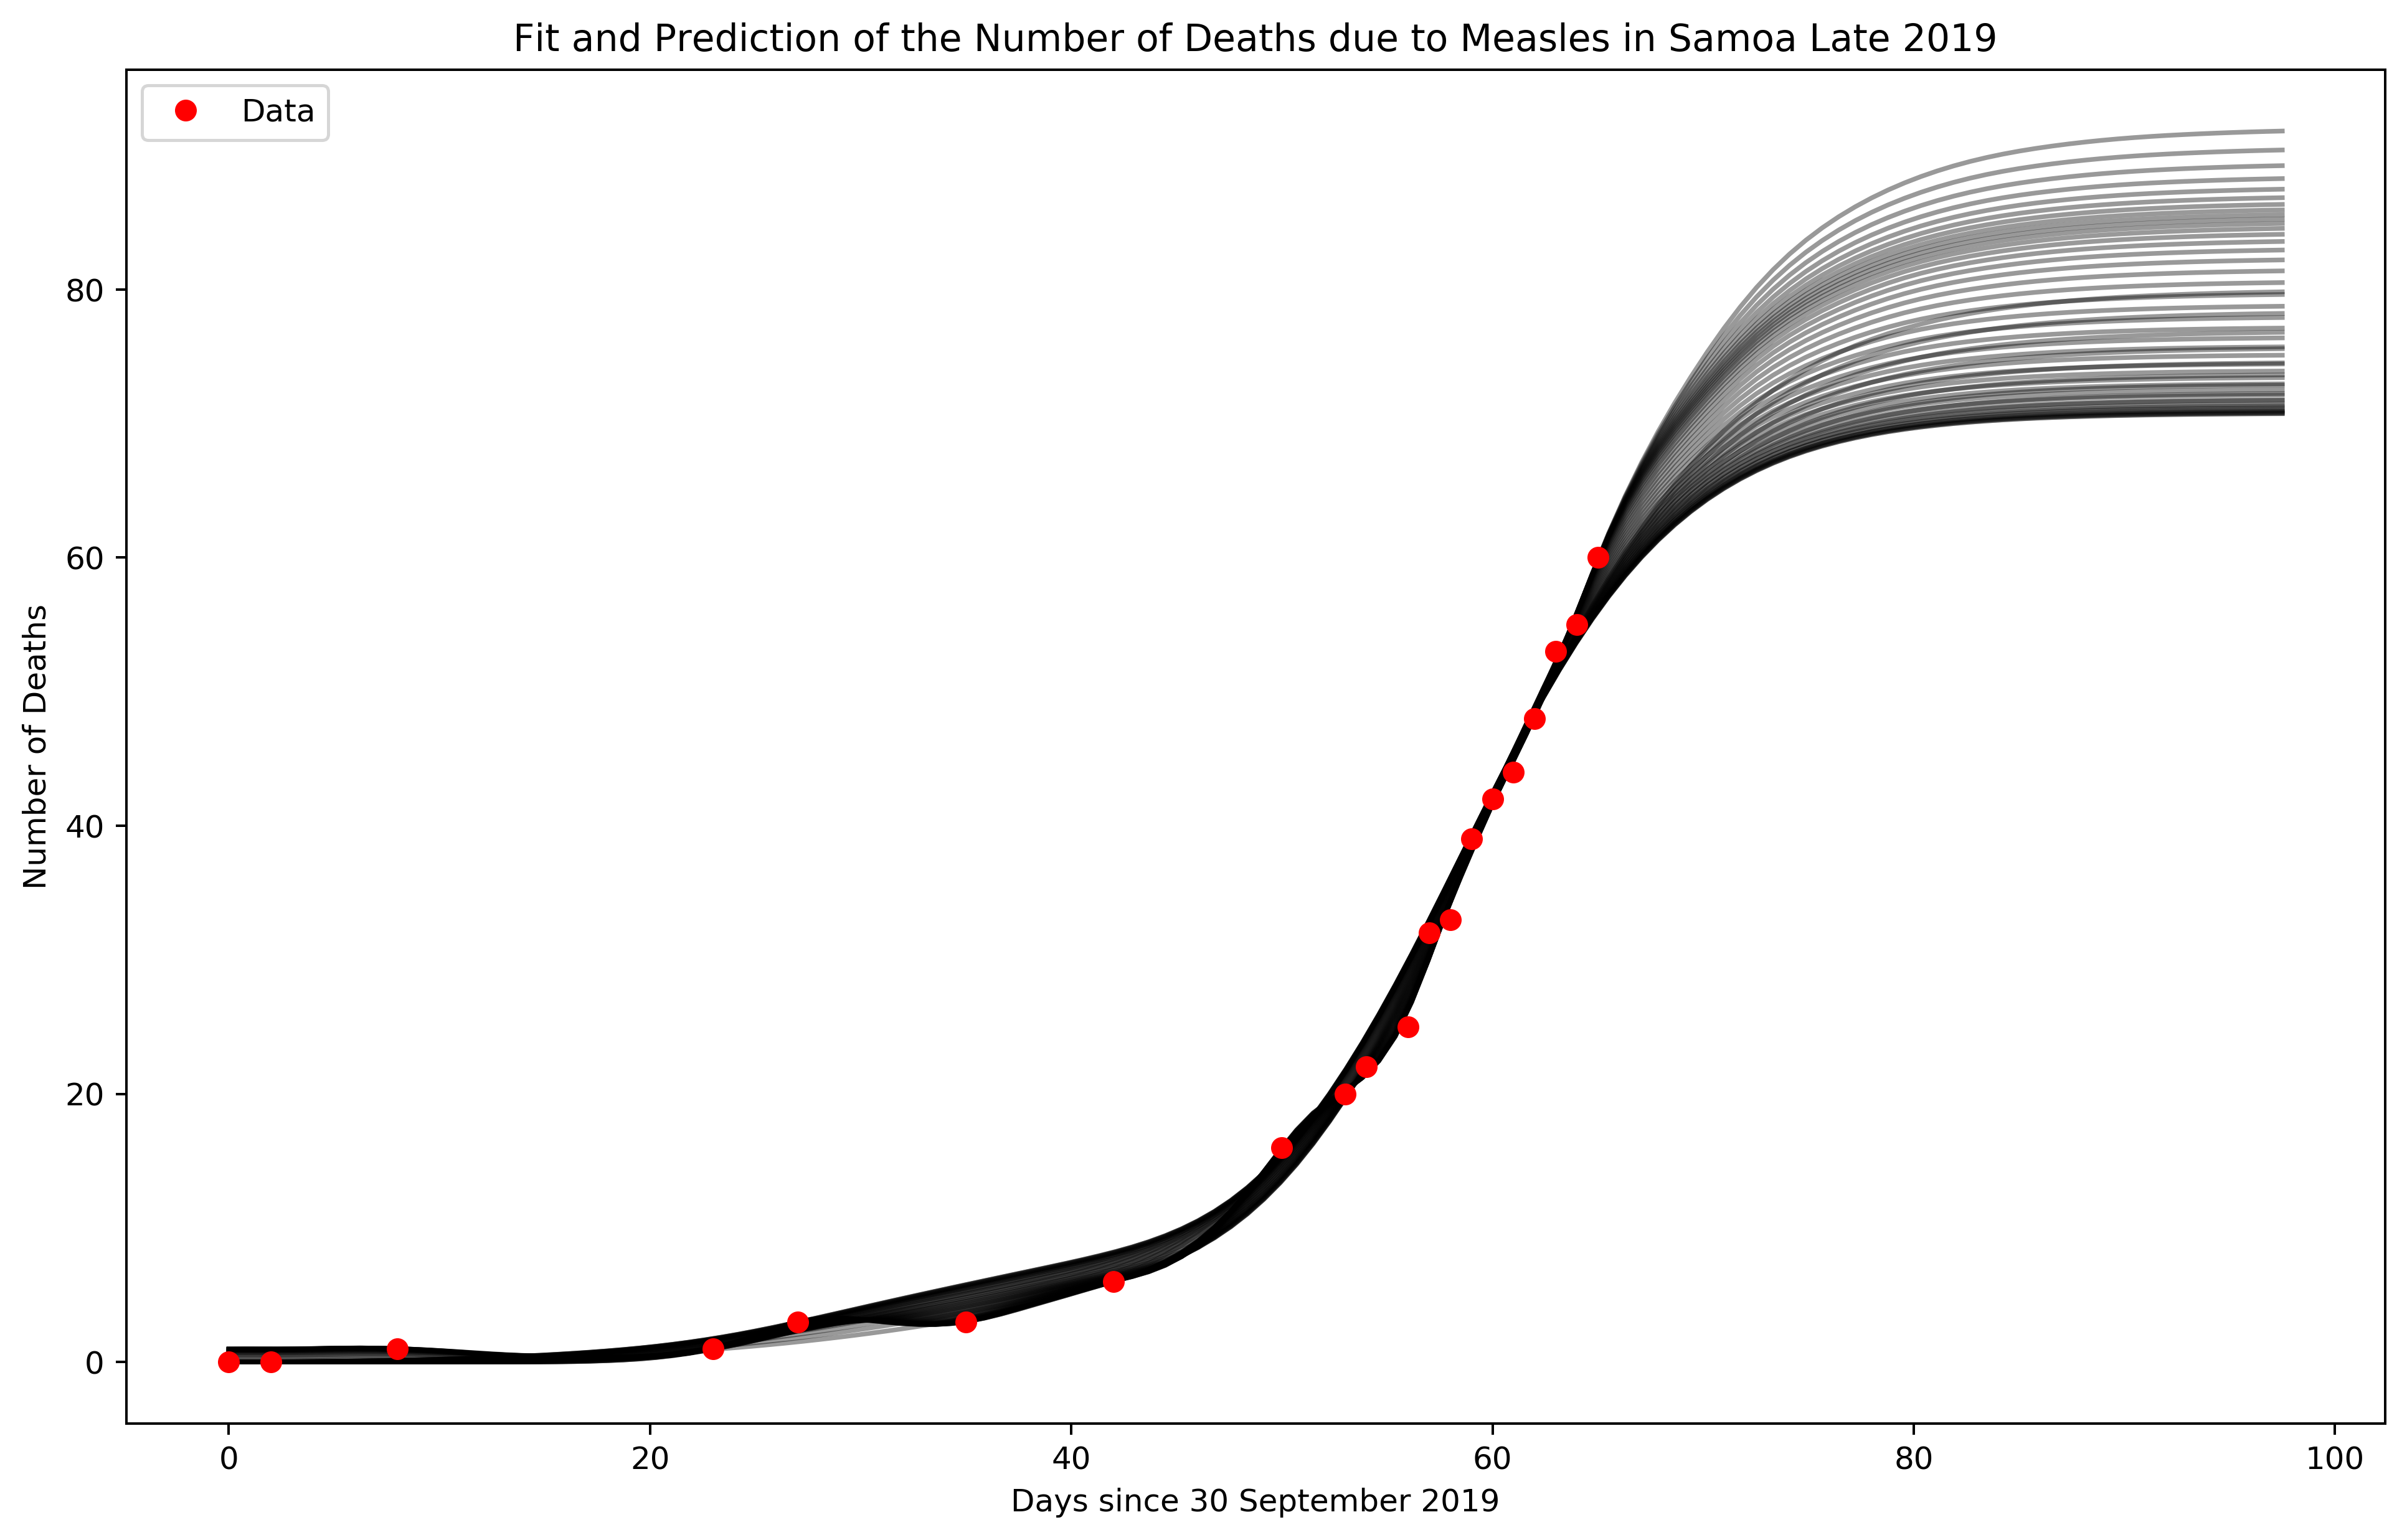

In [23]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

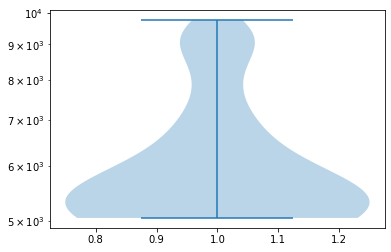

In [24]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
plt.yscale('log')

(0, 0.04)

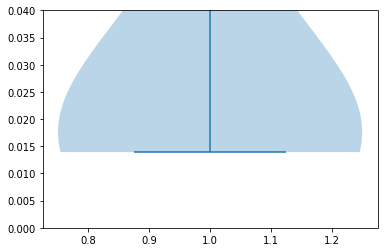

In [25]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
plt.ylim(0,0.04)